# Showcase of the ensembling process

Input to the _Scoring Ensembling_ module are the algorithm instances selected in the _Algorithm Instance Selection_ step.
All algorithm instances are executed on the target time series and their anomaly scores are collected.
AutoTSAD ensembling strategy uses the following components:
- Base models: Algorithm instances from the previous step
    - different instantiations (hyperparameters) of 8 TSAD algorithms
    - hyperparameters are selected on synthetically generated training data
- Normalization:
    - required because of the score-wise aggregation and the model selection step
    - IF-scores are inverted, the other algorithm results are already correctly oriented
    - We use Gaussian scaling on scorings
- (Model selection):
   - Additional step to reduce bias
   - We select the top-6 algorithm instances based on aggregated ranking of 8 different ranking strategies
- Model combination strategy:
    - score-wise
    - max, mean, or maximum-over-threshold (which is a variation of the *thresh method* [sect. 5.6, OUTLIER ENSEMBLES])

In this notebook, we show the ensembling process for an example time series.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stumpy
import json

from matplotlib.legend_handler import HandlerNpoints
from matplotlib.lines import Line2D
from nx_config.test_utils import update_section
from sklearn.preprocessing import MinMaxScaler

from common import PROJECT_ROOT
from autotsad.config import config
from autotsad.dataset import TestDataset

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

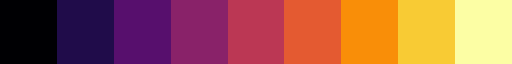

In [2]:
cm = matplotlib.colormaps["inferno"].resampled(9)
cm

In [3]:
# # Load data
# testdata_path = PROJECT_ROOT / "data" / "synthetic" / "gt-2.csv"
# testdataset = TestDataset.from_file(testdata_path)
# testdataset.plot()

In [4]:
# tmp_path = PROJECT_ROOT / "tmp"
# scores_path = tmp_path / "scores"
# max_instances = 3
# normalization = "gaussian"
# aggregation = "mean"

# columns = ["algorithm", "params", "no_datasets", "mean_train_quality", "mean_train_runtime"]
# example_ranked_instances = [
#     ["stomp","{\"anomaly_window_size\": 100}",60,0.8850125075532055,13.226133444444441],
#     ["grammarviz","{\"alphabet_size\": 6, \"anomaly_window_size\": 100, \"normalization_threshold\": 0.1, \"paa_transform_size\": 5}",9,0.43411360997233117,1.2185215833333336],
#     ["dwt_mlead","{\"quantile_epsilon\": 0.1, \"start_level\": 3}",2,0.3093008298373132,0.3655261666666667],
#     ["torsk","{\"context_window_size\": 10, \"density\": 0.01, \"imed_loss\": false, \"input_map_scale\": 0.125, \"input_map_size\": 100, \"prediction_window_size\": 5, \"scoring_large_window_size\": 100, \"scoring_small_window_size\": 10, \"spectral_radius\": 2.0, \"train_window_size\": 100, \"transient_window_size\": 20}",1,0.12157835188957741,1.982246319444445],
# ]
# df_instances = pd.DataFrame(example_ranked_instances, columns=columns)
# df_instances["params"] = df_instances["params"].apply(json.loads)
# df_instances

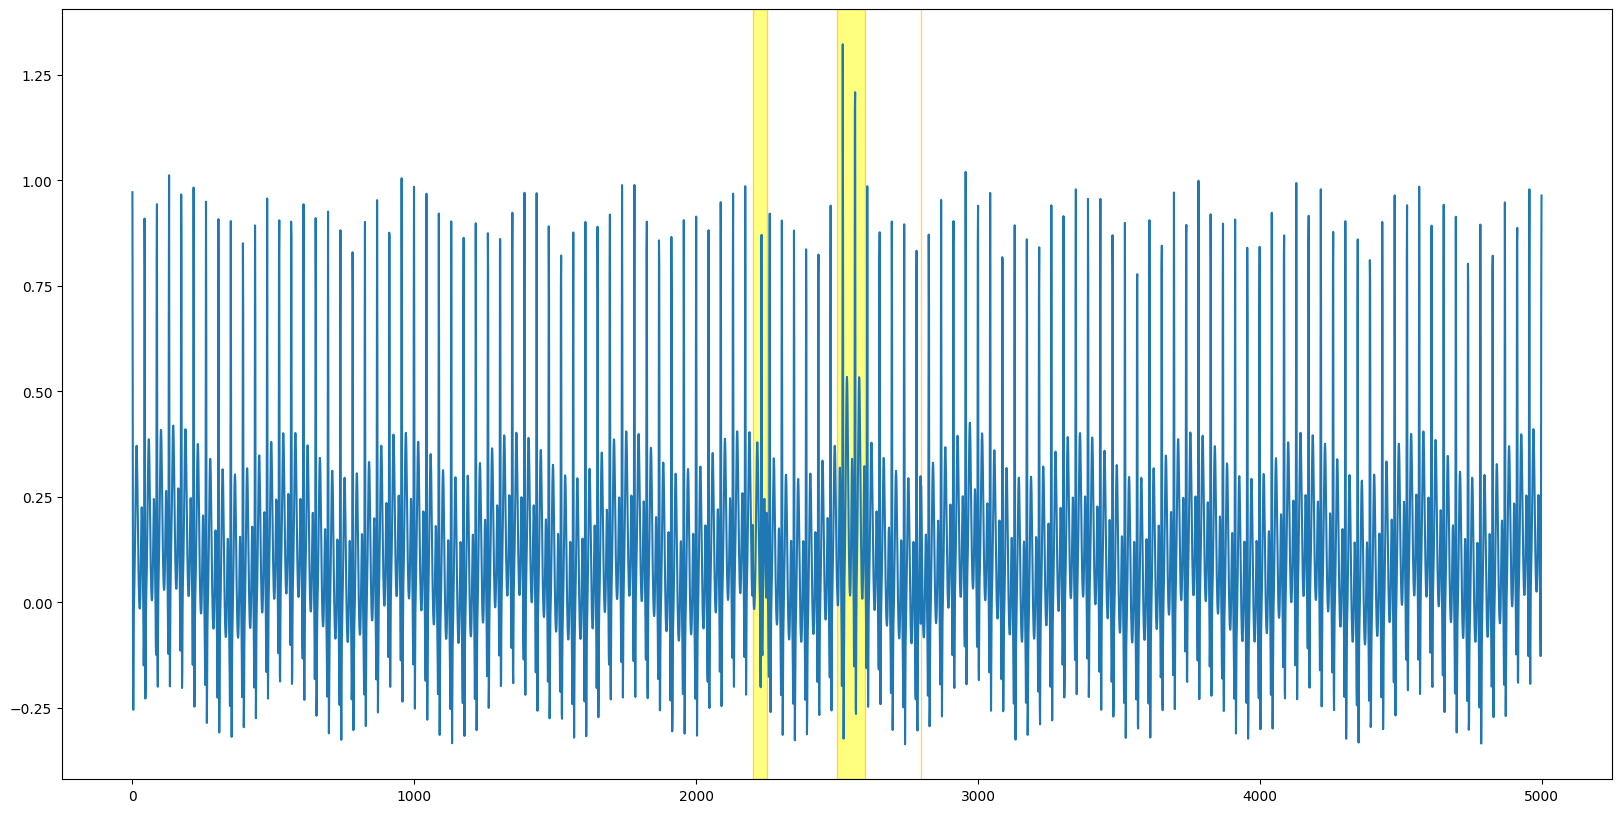

In [5]:
from common import generate_intro_example_data

# Load and plot synthetic ECG signal
offset = 2000
_ = generate_intro_example_data(anomaly_region_offset=offset)
testdata_path = PROJECT_ROOT / "data" / "paper-example.csv"
testdataset = TestDataset.from_file(testdata_path)
testdataset.plot()

In [6]:
tmp_path = PROJECT_ROOT / "tmp"
scores_path = tmp_path / "scores"
max_instances = 3
normalization = "gaussian"
aggregation = "mean"

columns = ["algorithm", "params", "no_datasets", "mean_train_quality", "mean_train_runtime"]
example_ranked_instances = [
    ["kmeans","{\"n_clusters\": 50, \"window_size\": 100}",12,0.7341429701520151,0.2668441851851852],
    ["torsk","{\"context_window_size\": 10, \"density\": 0.01, \"imed_loss\": false, \"input_map_scale\": 0.125, \"input_map_size\": 100, \"prediction_window_size\": 5, \"scoring_large_window_size\": 100, \"scoring_small_window_size\": 10, \"spectral_radius\": 2.0, \"train_window_size\": 100, \"transient_window_size\": 20}",4,0.20882783106784886,4.788019740740741],
#     ["subsequence_knn","{\"distance_metric_order\": 2, \"leaf_size\": 20, \"method\": \"largest\", \"n_neighbors\": 50, \"radius\": 1.0, \"window_size\": 384}",3,0.46884720333445445,0.5178477037037037],
#     ["dwt_mlead","{\"quantile_epsilon\": 0.1, \"start_level\": 3}",1,0.2780991058275233,0.3922360000000001],
    ["grammarviz","{\"alphabet_size\": 6, \"anomaly_window_size\": 384, \"normalization_threshold\": 0.1, \"paa_transform_size\": 5}",1,0.42291306732981837,4.822893074074074],
#     ["subsequence_if","{\"bootstrap\": true, \"max_features\": 1.0, \"max_samples\": 1.0, \"n_trees\": 500, \"window_size\": 384}",4,0.5126813308520584,5.950281777777779],
#     ["stomp","{\"anomaly_window_size\": 384}",1,0.5449923191242143,1.1367466296296298],
    ["subsequence_lof","{\"distance_metric_order\": 2, \"leaf_size\": 20, \"n_neighbors\": 50, \"window_size\": 384}",1,0.4719171202166219,0.3825691851851852],
]
df_instances = pd.DataFrame(example_ranked_instances, columns=columns)
df_instances["params"] = df_instances["params"].apply(json.loads)
df_instances

,algorithm,params,no_datasets,mean_train_quality,mean_train_runtime
0,kmeans,"{'n_clusters': 50, 'window_size': 100}",12,0.734143,0.266844
1,torsk,"{'context_window_size': 10, 'density': 0.01, '...",4,0.208828,4.788020
2,grammarviz,"{'alphabet_size': 6, 'anomaly_window_size': 38...",1,0.422913,4.822893
3,subsequence_lof,"{'distance_metric_order': 2, 'leaf_size': 20, ...",1,0.471917,0.382569


In [7]:
# adjust default config
update_section(
    config.general,
    tmp_path=tmp_path,
    cache_key=testdataset.hexhash,
    progress=False,
    n_jobs=1,
    use_timer=False,
    memory_limit_mb=1024,
    testing_timeout_s=10*60,
    score_normalization_method=normalization,
    score_aggregation_method=aggregation,
)
update_section(
    config.optimization,
    optuna_storage_type="sqlite",
    disabled=True,
)

# and then import modules
from autotsad.dataset import TrainingDatasetCollection
from autotsad.system.execution.main import execute_on_test
from autotsad.system.execution.aggregation import algorithm_instances, load_scores, aggregate_scores
from autotsad.system.execution.algo_selection import rank_aggregation_mim
from autotsad.streamlit_app._lib.plt_plotting import adjust_names
from autotsad.util import mask_to_slices

2024-07-08 16:19:44.141 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-07-08 16:19:44.148 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-07-08 16:19:44.151 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-07-08 16:19:44.155 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-07-08 16:19:44.162 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-07-08 16:19:44.165 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-07-08 16:19:44.168 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-07-08 16:19:44.176 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [8]:
# execute algorithm instances on the test data
config.general.cache_dir().mkdir(parents=True, exist_ok=True)
dataset_collection = TrainingDatasetCollection(test_data=testdataset)
results = execute_on_test(dataset_collection, df_instances, score_dirpath=scores_path)
results = results[~results["quality"].isna()]
results = results[algorithm_instances(results).isin(algorithm_instances(df_instances))].reset_index(drop=True)
results

Loading algorithm execution results from cache


,algorithm,params,no_datasets,mean_train_quality,mean_train_runtime,dataset,quality,duration,dataset_id
0,kmeans,"{'n_clusters': 50, 'window_size': 100}",12,0.734143,0.266844,paper-example,0.806220,0.985241,38fcba456452f33911fb75695b9ab295
1,torsk,"{'context_window_size': 10, 'density': 0.01, '...",4,0.208828,4.788020,paper-example,0.243257,5.751158,38fcba456452f33911fb75695b9ab295
2,grammarviz,"{'alphabet_size': 6, 'anomaly_window_size': 38...",1,0.422913,4.822893,paper-example,0.289509,3.430219,38fcba456452f33911fb75695b9ab295
3,subsequence_lof,"{'distance_metric_order': 2, 'leaf_size': 20, ...",1,0.471917,0.382569,paper-example,0.155945,2.120041,38fcba456452f33911fb75695b9ab295


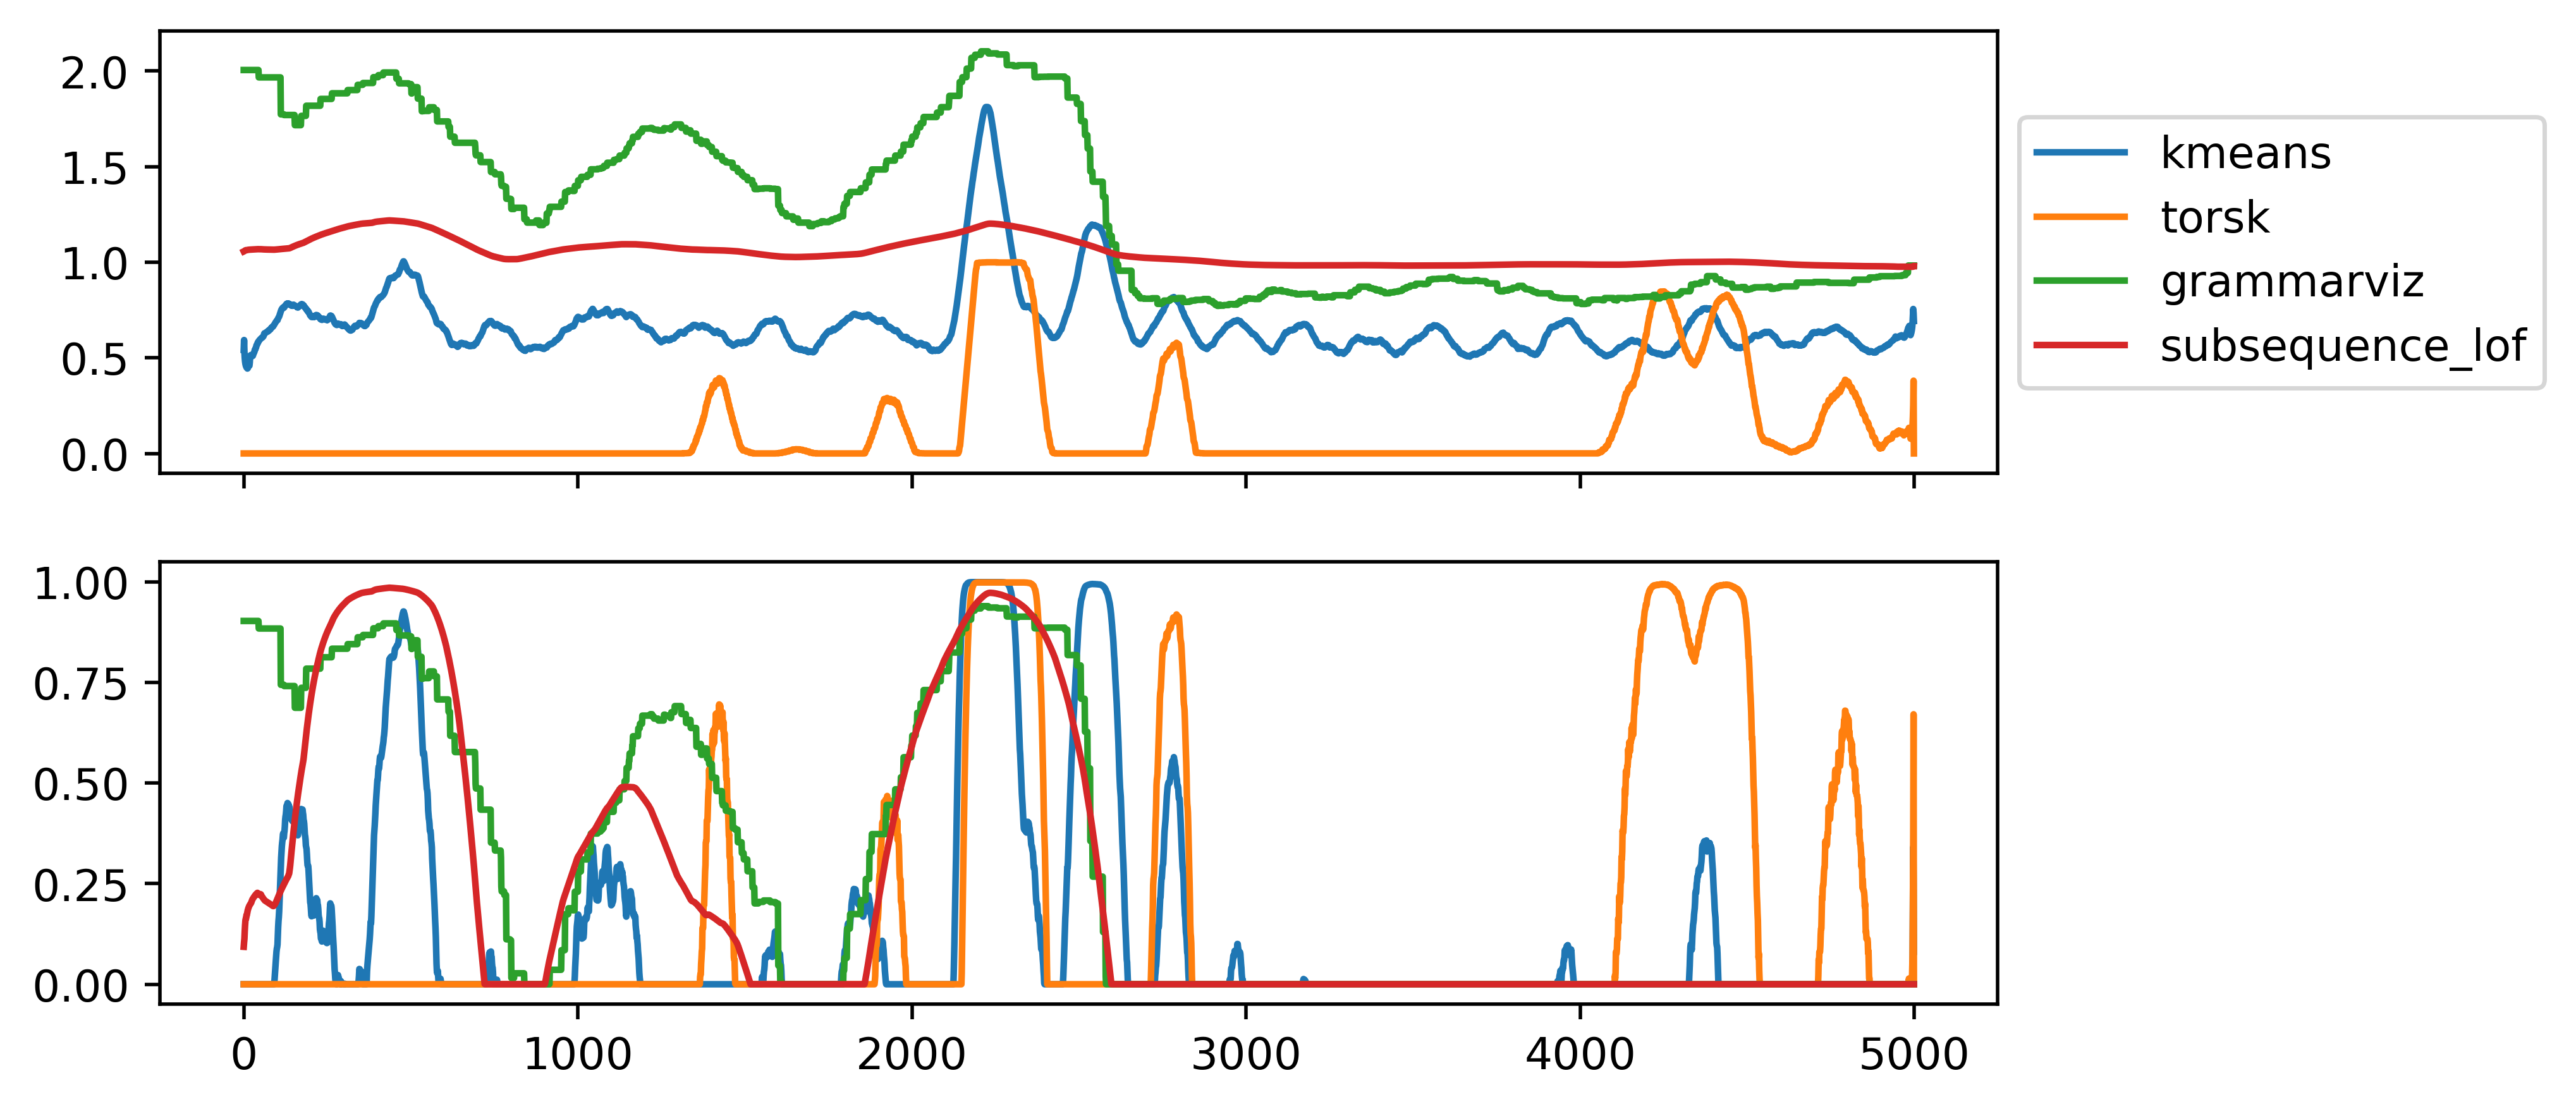

In [9]:
# load scores and normalized scores
instances = algorithm_instances(results)
df_scores = load_scores(instances,
                     dataset_id=testdataset.hexhash,
                     base_scores_path=scores_path,
                     normalization_method=None,
                     ensure_finite=True)
df_normalized_scores = load_scores(instances,
                                dataset_id=testdataset.hexhash,
                                base_scores_path=scores_path,
                                normalization_method=normalization,
                                ensure_finite=True)
fig, axs = plt.subplots(2, 1, figsize=(7.5, 4), dpi=500, sharex="col")
for c in df_scores.columns:
    label = c.split("-")[0]
    axs[0].plot(df_scores[c], label=label)
    axs[1].plot(df_normalized_scores[c], label=label)
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
# shuffle results to see ranking changes
# results = results.sample(frac=1, random_state=config.general.seed).reset_index(drop=True)
# sort by name length to improve legend display
results = results.sort_values(by=["algorithm"], key=lambda x: x.apply(len)).reset_index(drop=True)
results

,algorithm,params,no_datasets,mean_train_quality,mean_train_runtime,dataset,quality,duration,dataset_id
0,torsk,"{'context_window_size': 10, 'density': 0.01, '...",4,0.208828,4.788020,paper-example,0.243257,5.751158,38fcba456452f33911fb75695b9ab295
1,kmeans,"{'n_clusters': 50, 'window_size': 100}",12,0.734143,0.266844,paper-example,0.806220,0.985241,38fcba456452f33911fb75695b9ab295
2,grammarviz,"{'alphabet_size': 6, 'anomaly_window_size': 38...",1,0.422913,4.822893,paper-example,0.289509,3.430219,38fcba456452f33911fb75695b9ab295
3,subsequence_lof,"{'distance_metric_order': 2, 'leaf_size': 20, ...",1,0.471917,0.382569,paper-example,0.155945,2.120041,38fcba456452f33911fb75695b9ab295


In [11]:
# compute rankings
df_results, df_ranks = rank_aggregation_mim(results, df_normalized_scores, max_instances=max_instances)
df_ranks += 1
df_results = df_results.iloc[:max_instances, :]
df_results

,algorithm,params,no_datasets,mean_train_quality,mean_train_runtime,dataset,quality,duration,dataset_id,q
1,kmeans,"{'n_clusters': 50, 'window_size': 100}",12,0.734143,0.266844,paper-example,0.806220,0.985241,38fcba456452f33911fb75695b9ab295,1.000000
0,torsk,"{'context_window_size': 10, 'density': 0.01, '...",4,0.208828,4.788020,paper-example,0.243257,5.751158,38fcba456452f33911fb75695b9ab295,0.136364
3,subsequence_lof,"{'distance_metric_order': 2, 'leaf_size': 20, ...",1,0.471917,0.382569,paper-example,0.155945,2.120041,38fcba456452f33911fb75695b9ab295,0.250411


In [12]:
# individual rankings
df_ranks

,training-quality,training-result,affinity-propagation-clustering,kmedoids-clustering,greedy-euclidean,greedy-annotation-overlap,mmq-euclidean,mmq-annotation-overlap,aggregated-minimum-influence
torsk-e21e28ed7f25b8f9b47c35d642e43da5,4,4,1,2,2,2,3,4,2
kmeans-2e8a1c55dd5b73643efb51b079c8ad54,1,1,5,1,1,1,1,1,1
grammarviz-2dc9fb4e12e764c5adc225cd6187b9ed,3,3,5,3,3,4,4,3,4
subsequence_lof-bfae98861f665869ed5e92735b7ce791,2,2,2,5,4,3,2,2,3


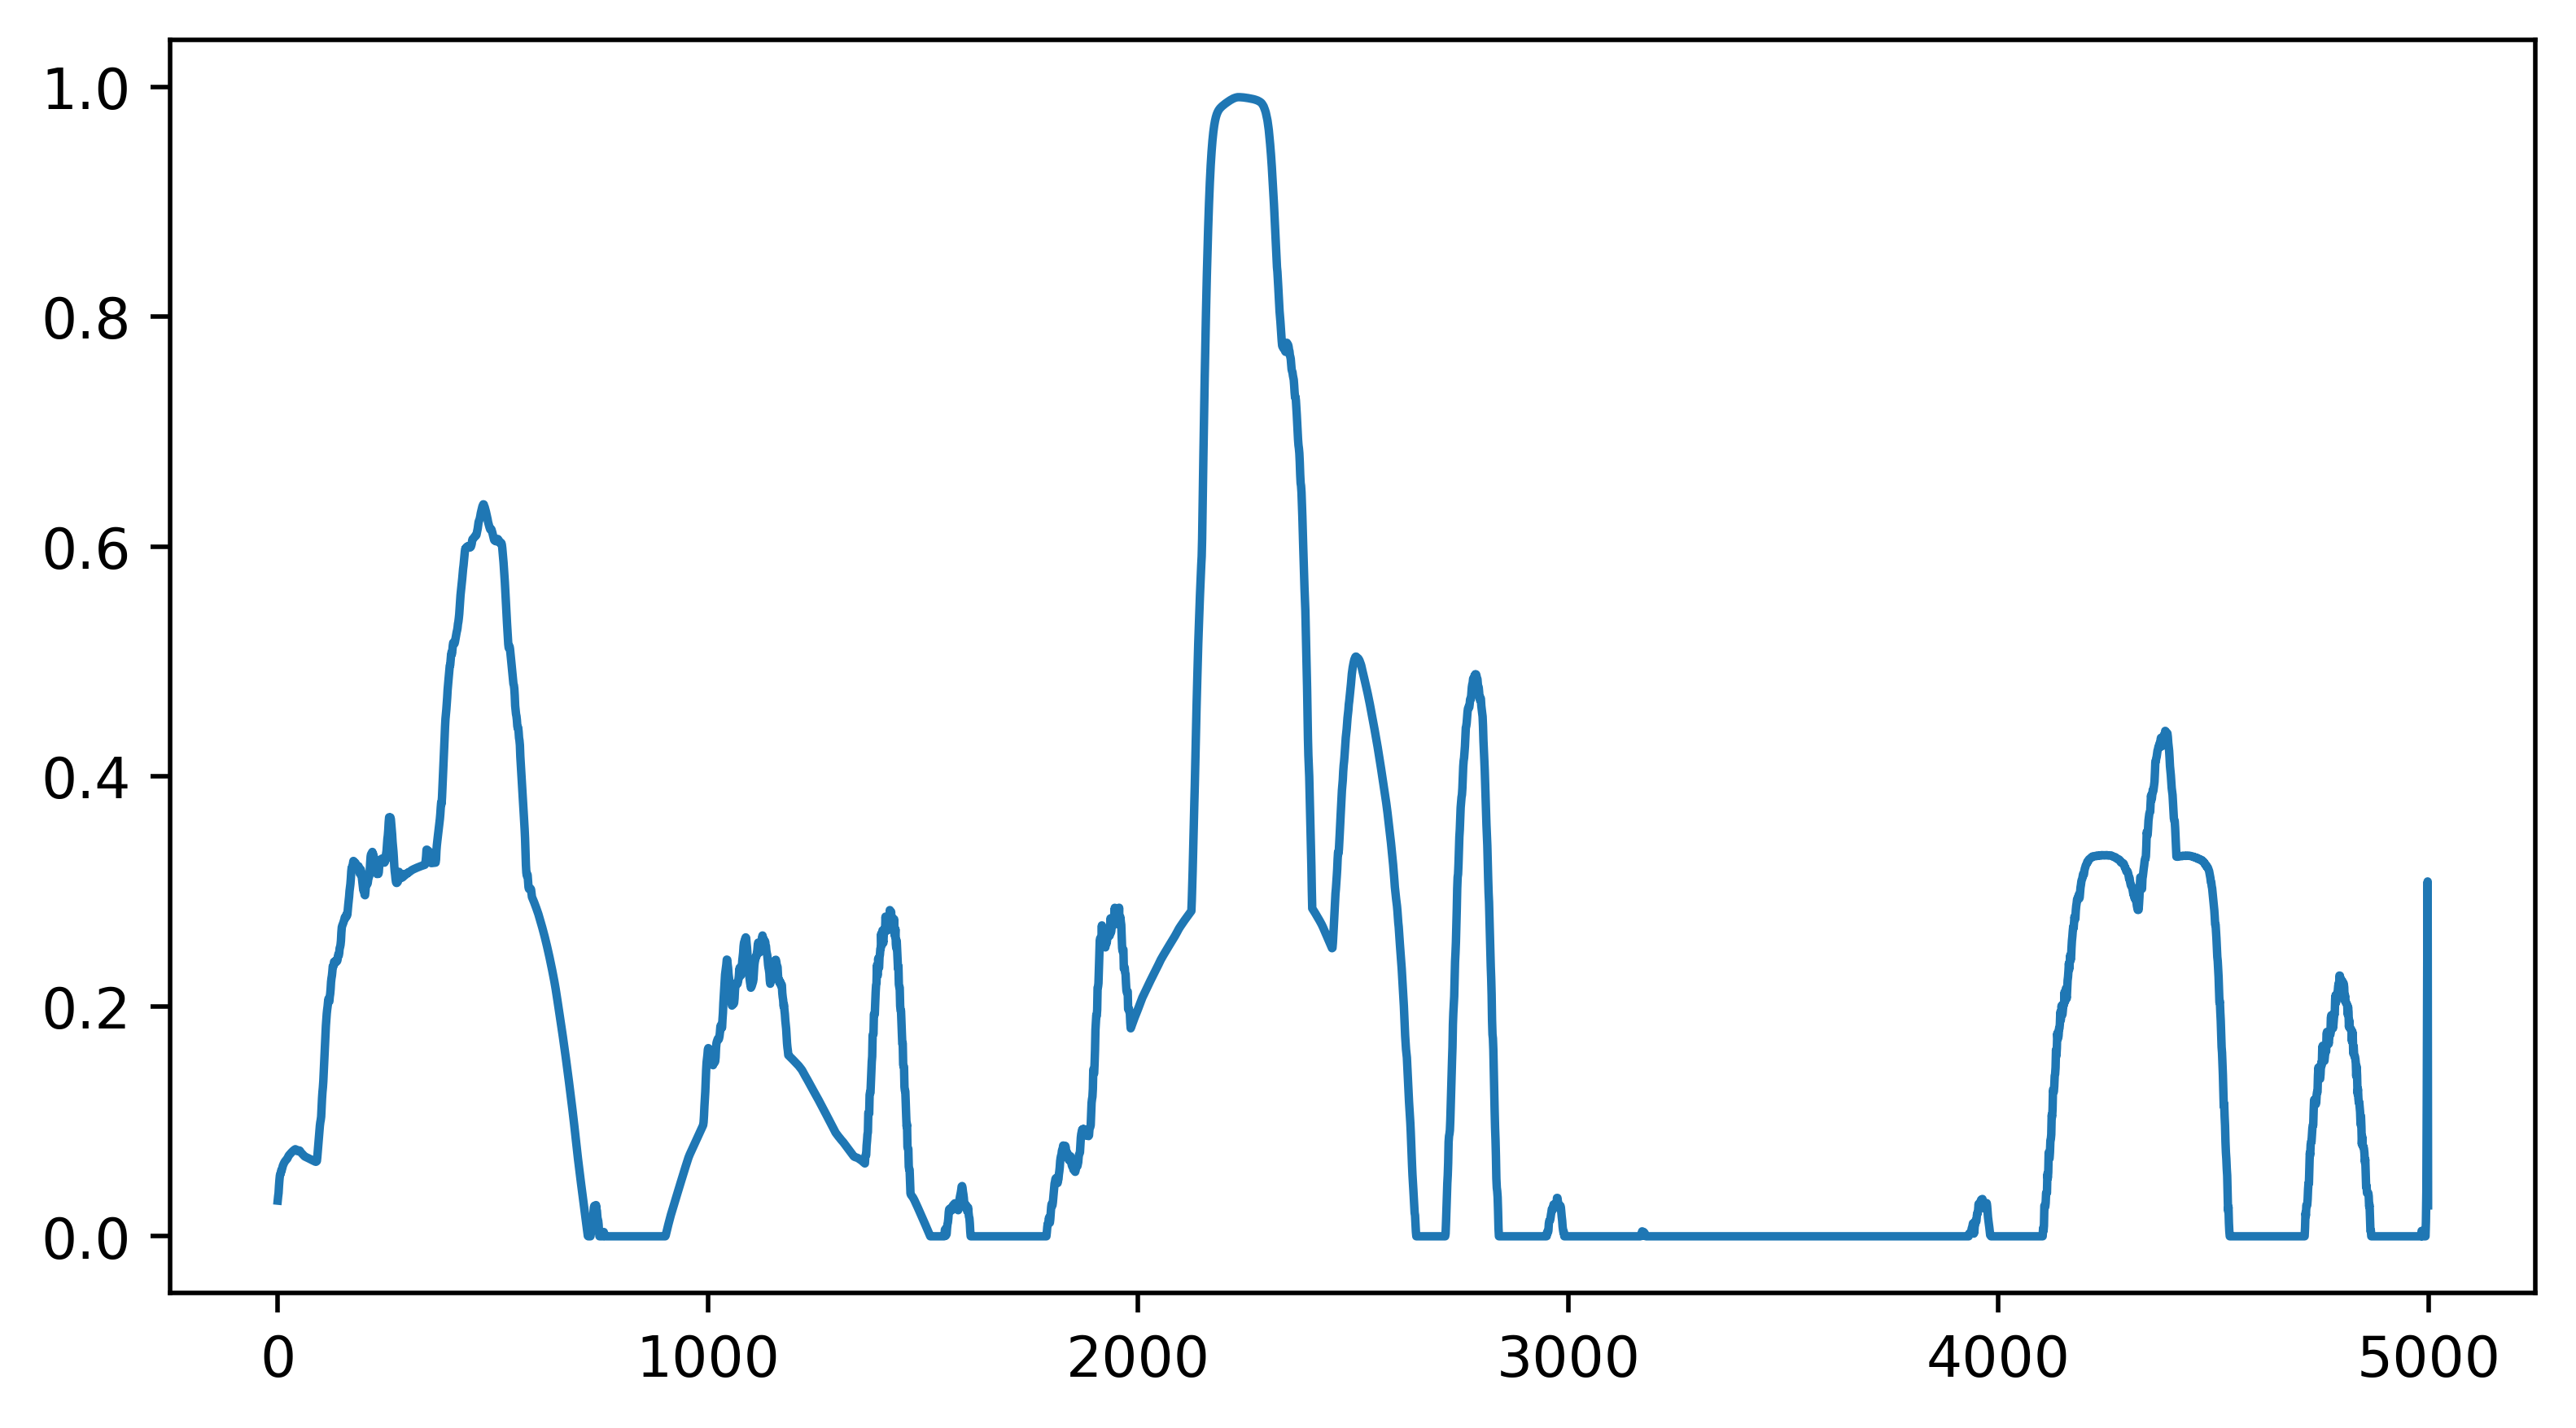

In [13]:
# create combined score
combined_score = aggregate_scores(df_normalized_scores[algorithm_instances(df_results)].values, agg_method=aggregation)
plt.figure(figsize=(7.5, 4), dpi=500)
plt.plot(combined_score, label="Combined score")
plt.show()

In [14]:
# adjust names
df_scores.columns = [adjust_names(c.split("-")[0]) for c in df_scores.columns]
df_normalized_scores.columns = [adjust_names(c.split("-")[0]) for c in df_normalized_scores.columns]
df_ranks.columns = [adjust_names(c) for c in df_ranks.columns]
df_ranks.index = [adjust_names(a.split("-")[0]) for a in df_ranks.index]
algorithms = results["algorithm"].apply(adjust_names).tolist()
print(algorithms)

['Torsk', 'kMeans', 'GrammarViz', 'Sub-LOF']


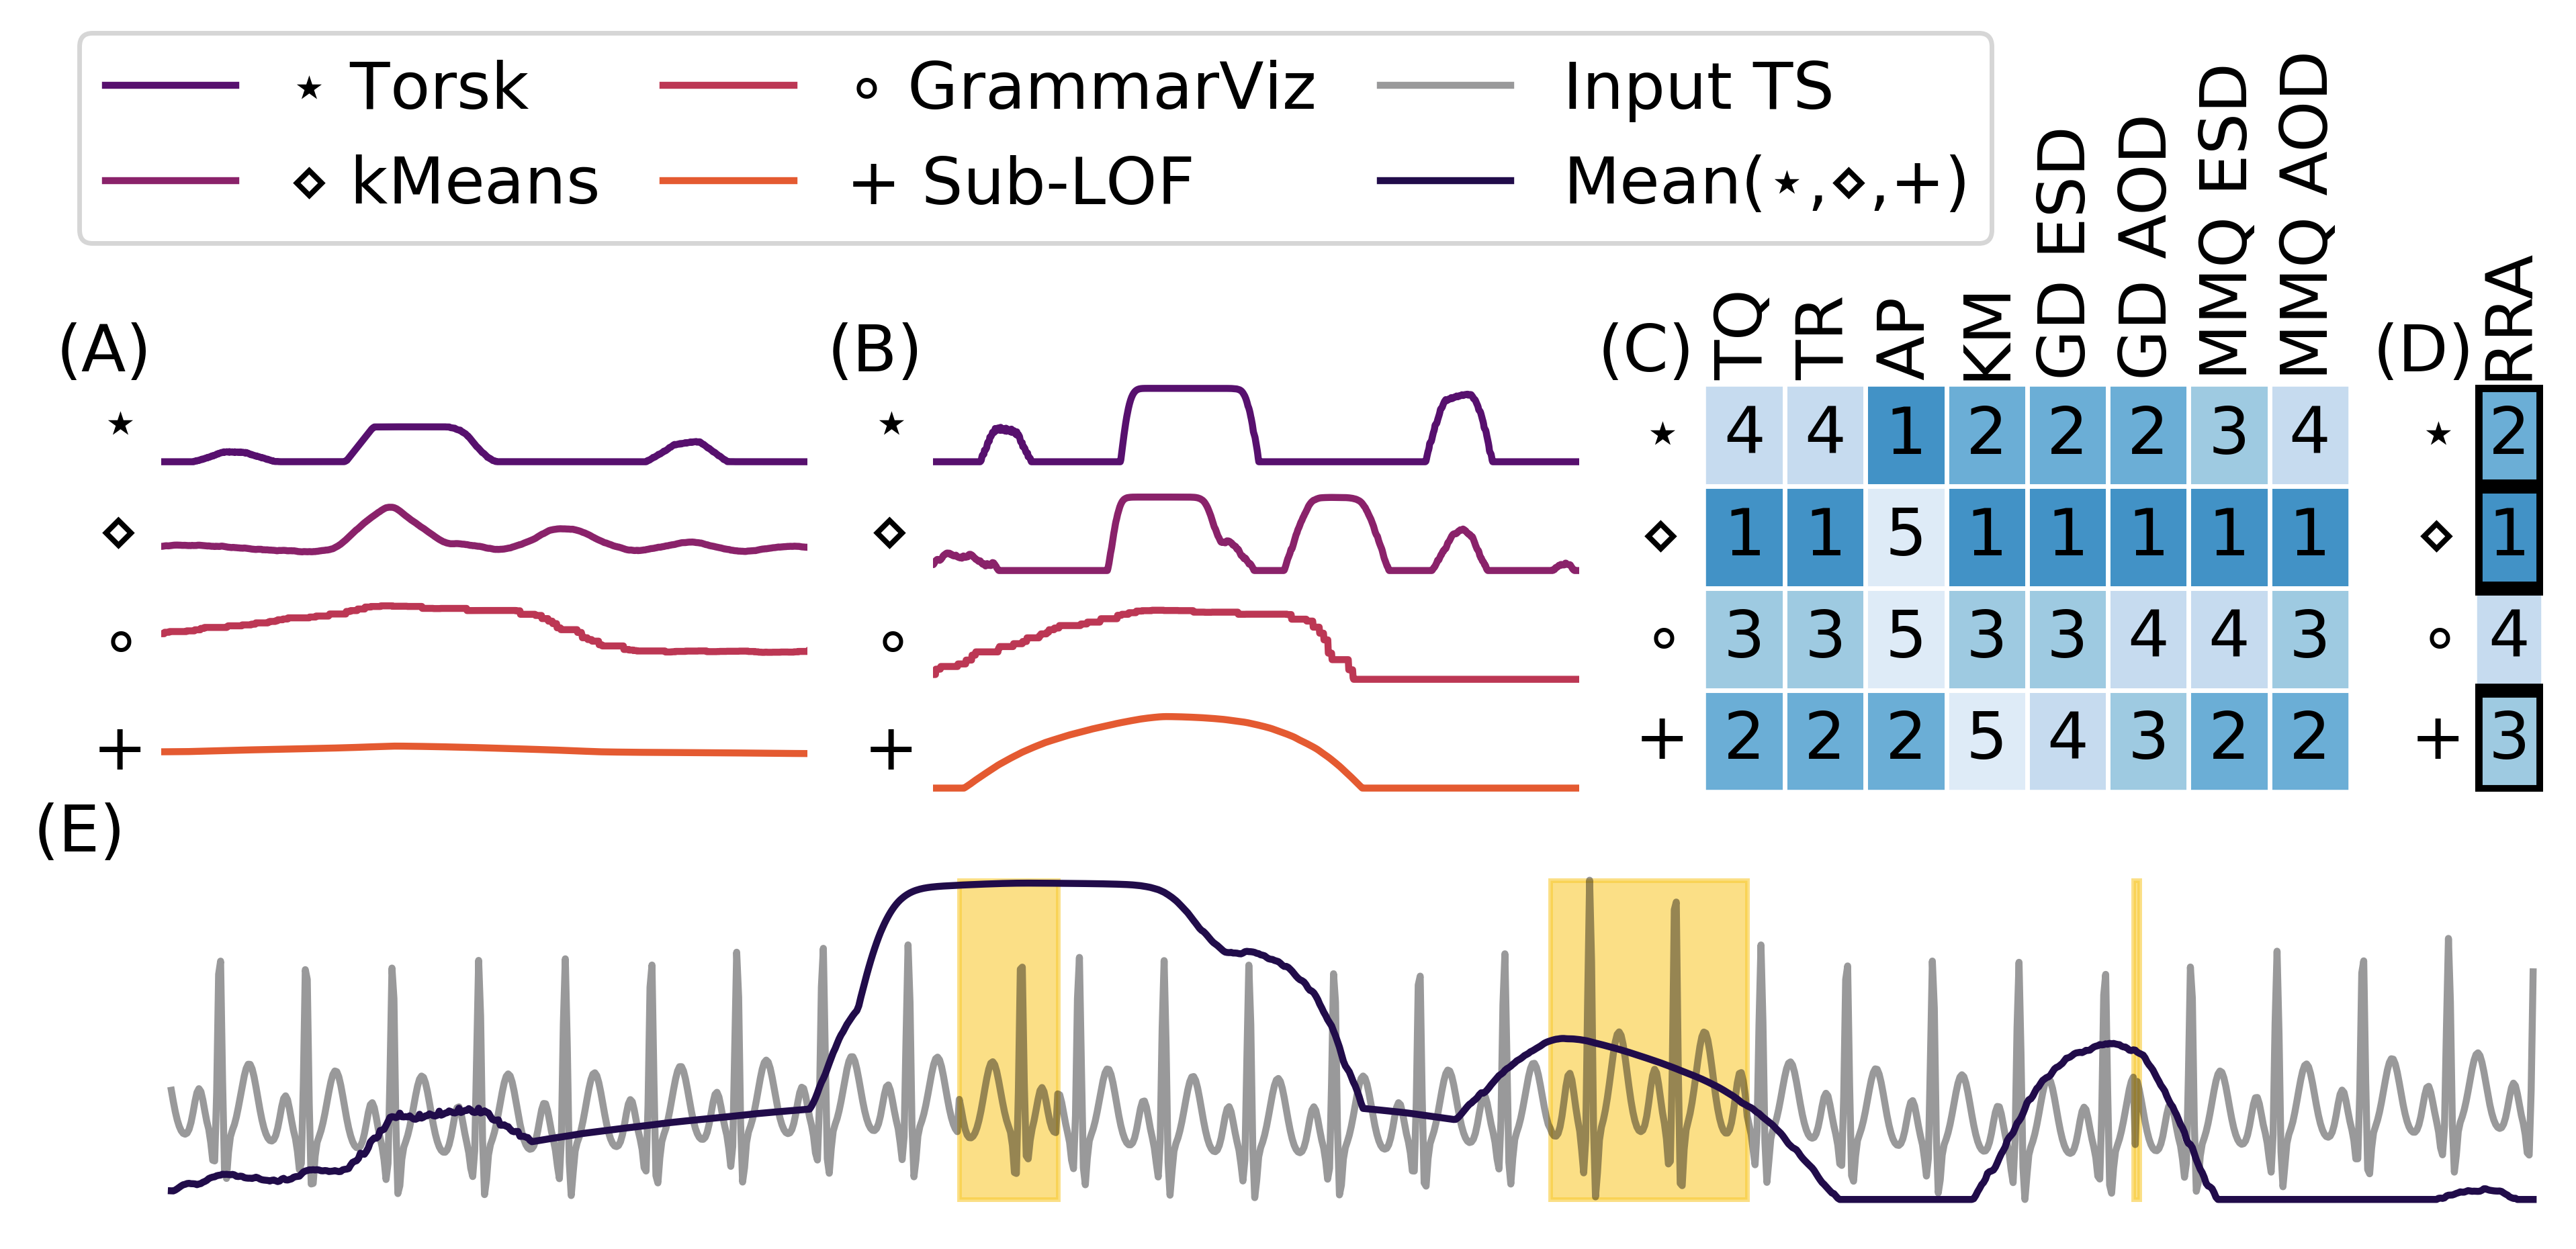

In [15]:
from matplotlib.patches import Rectangle

plt.rcParams["font.size"] = 14

show_anomalies = True
show_axis = False
use_strike_instead_of_box = False
colors = cm.colors[2:-1]
ts_color = cm.colors[0]
combined_score_color = cm.colors[1]
anomaly_highlight_color = cm.colors[-2]
anomaly_highlight_color_alpha = 0.6
strike_color = "black"
algo_markers = ["$\\star$", "$\\diamond$", "$\\circ$", "$+$", "$\\triangleleft$", "$\\square$"]

start_idx = offset - 200
end_idx = offset + 1000

# prepare data
index = np.arange(testdataset.data.shape[0])[start_idx:end_idx]
data = testdataset.data[start_idx:end_idx]
data = MinMaxScaler().fit_transform(data.reshape(-1, 1)).ravel()
anomalies = mask_to_slices(testdataset.label)
scores = df_scores.iloc[start_idx:end_idx, :]
normalized_scores = df_normalized_scores.iloc[start_idx:end_idx, :]
final_score = combined_score[start_idx:end_idx]

scores_max = np.amax(scores.values)
scores_min = np.amin(scores.values)

worst_algo_idx = np.argmax(df_ranks["RRA"].values)
worst_algo = df_ranks.index[worst_algo_idx]

# plot
extra_artists = []
fig = plt.figure(figsize=(7.5, 3.5), dpi=500, layout="constrained")
grid_shape = (8, 13)
# combined score (and timeseries):
ax0 = plt.subplot2grid(grid_shape, (4, 0), rowspan=4, colspan=13)
# original scores:
ax_scores = [plt.subplot2grid(grid_shape, (i, 0), rowspan=1, colspan=4) for i in range(4)]
# normalized scores:
ax_norm_scores = [plt.subplot2grid(grid_shape, (i, 4), rowspan=1, colspan=4) for i in range(4)]
# rankings:
ax_ranks = plt.subplot2grid(grid_shape, (0, 8), rowspan=4, colspan=4)
ax_rra = plt.subplot2grid(grid_shape, (0, 12), rowspan=4, colspan=1)

# plot data and combined scoring
ax0.plot(index, data, color=ts_color, alpha=0.4, label="Input TS")

if show_anomalies:
    # mark anomalies
    y_min = data.min(axis=None)
    y_max = data.max(axis=None)
    for begin, end in anomalies:
        width = end - begin
        if width < 2:
            width += 2
            begin -= 1
        ax0.add_patch(Rectangle((begin, y_min), width, y_max-y_min, color=anomaly_highlight_color, alpha=anomaly_highlight_color_alpha))
markers = []
for i, algo in enumerate(algorithms):
    if algo == worst_algo:
        continue
    markers.append(algo_markers[i])
ax0.plot(index, final_score, label=f"Mean({','.join(markers)})", color=combined_score_color)
if not show_axis:
    ax0.axis("off")
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlim(index[0] - 5, index[-1] + 5)
ax0.autoscale(enable=True, axis="y", tight=False)

# plot scores and normalized scores
for i, c in zip(range(len(algorithms)), colors):
    algo = algorithms[i]
    label = f"{algo_markers[i]} {algo}"

    ax_scores[i].plot(index, scores[algo].values, label=label, color=c)
    # extra_artists.append(
    #     ax_scores[i].text(-0.05*index.shape[0], 0.5*scores_max, algo, ha="right", va="center", color=c, fontweight="bold")
    # )
    extra_artists.append(
        ax_scores[i].text(-.07, 0.5, algo_markers[i], ha="center", va="center", color="black", fontweight="bold", transform=ax_scores[i].transAxes)
    )
    if not show_axis:
        ax_scores[i].axis("off")
    ax_scores[i].set_xticks([])
    ax_scores[i].set_yticks([])
    extra_lim = 0.05 * (scores_max - scores_min)
    ax_scores[i].set_ylim(scores_min-extra_lim, scores_max+extra_lim)
    # ax_scores[i].set_xlim(index[0]-0.1*index.shape[0], index[-1])
    ax_scores[i].autoscale(enable=True, axis="x", tight=True)

    ax_norm_scores[i].plot(index, normalized_scores[algo].values, label=label, color=c)
    extra_artists.append(
        ax_norm_scores[i].text(-.07, 0.5, algo_markers[i], ha="center", va="center", color="black", fontweight="bold", transform=ax_norm_scores[i].transAxes)
    )
    if not show_axis:
        ax_norm_scores[i].axis("off")
    ax_norm_scores[i].set_xticks([])
    ax_norm_scores[i].set_yticks([])
    ax_norm_scores[i].set_ylim(-0.05, 1.05)
    # ax_norm_scores[i].set_xlim(index[0], index[-1]+0.1*index.shape[0])
    ax_norm_scores[i].autoscale(enable=True, axis="x", tight=True)

# plot ranking matrix
y_bounds = (0, df_ranks.shape[0] - 1)
x_bounds = (0, df_ranks.shape[1] - 2)
for i, rm in enumerate(df_ranks.columns[:-1]):
    extra_artists.append(
        ax_ranks.text(i, y_bounds[1] + 0.55, rm, ha="center", va="bottom", rotation=90)
    )
ax_ranks.imshow(df_ranks.iloc[::-1, :].values, cmap="Blues_r", vmin=-2, vmax=df_ranks.shape[0]+2, norm="linear", aspect="auto", interpolation="none")
for i in range(x_bounds[1]+1):
    for j in range(y_bounds[1]+1):
        ax_ranks.text(i, j, str(df_ranks.iloc[::-1, :].values[j, i]), ha="center", va="center", color="black")
if not show_axis:
    ax_ranks.spines["bottom"].set_color("white")
    ax_ranks.spines["top"].set_color("white")
    ax_ranks.spines["right"].set_color("white")
    ax_ranks.spines["left"].set_color("white")
ax_ranks.set_xlim(x_bounds[0] - 0.5, x_bounds[1] + 0.5)
ax_ranks.set_ylim(y_bounds[0] - 0.5, y_bounds[1] + 0.5)
ax_ranks.set_yticks(np.arange(y_bounds[1]) + 0.5)
ax_ranks.set_xticks(np.arange(x_bounds[1]) + 0.5)
ax_ranks.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)
ax_ranks.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False, labeltop=False)
ax_ranks.grid(which="major", axis="both", linestyle="-", linewidth=1, color="white")

# plot rra result
extra_artists.append(
    ax_rra.text(0, y_bounds[1] + 0.55, "RRA", ha="center", va="bottom", rotation=90)
)
ax_rra.imshow(df_ranks["RRA"].values[::-1].reshape(-1, 1), cmap="Blues_r", vmin=-2, vmax=df_ranks.shape[0]+2, norm="linear", aspect="auto", interpolation="none")
for j in range(y_bounds[1]+1):
    ax_rra.text(0, j, str(df_ranks["RRA"][::-1].values[j]), ha="center", va="center", color="black")
if not show_axis:
    ax_rra.spines["bottom"].set_color("white")
    ax_rra.spines["top"].set_color("white")
    ax_rra.spines["right"].set_color("white")
    ax_rra.spines["left"].set_color("white")
ax_rra.set_xlim(-0.5, 0.5)
ax_rra.set_ylim(y_bounds[0] - 0.5, y_bounds[1] + 0.5)
ax_rra.set_yticks(np.arange(y_bounds[1]) + 0.5)
ax_rra.set_xticks([])
ax_rra.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)
ax_rra.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False, labeltop=False)
ax_rra.grid(which="major", axis="x", linestyle="-", linewidth=1, color="white")
ax_rra.grid(which="major", axis="y", linestyle="-", linewidth=1, color="white")

# add algorithm icons to the matrices
for i in range(len(algorithms)):
    height = 1 / len(algorithms)
    pos_y = 1 - i * height - height / 2
    extra_artists.append(
        ax_ranks.text(-.07, pos_y, algo_markers[i], ha="center", va="center", color="black", fontweight="bold", transform=ax_ranks.transAxes)
    )
    extra_artists.append(
        ax_rra.text(-.6, pos_y, algo_markers[i], ha="center", va="center", color="black", fontweight="bold", transform=ax_rra.transAxes)
    )

# mark the selected algorithms
if use_strike_instead_of_box:
    # strike the worst algorithm
    # ax_scores[worst_algo_idx].hlines(scores_max/2, 0, index.shape[0], color=strike_color, linewidth=3)
    # ax_norm_scores[worst_algo_idx].hlines(0.5, 0, index.shape[0], color=strike_color, linewidth=3)
    # ax_ranks.hlines(y_bounds[1] - worst_algo_idx, x_bounds[0], x_bounds[1], color=strike_color, linewidth=3)
    ax_rra.hlines(y_bounds[1] - worst_algo_idx, -0.5, 0.5, color=strike_color, linewidth=3, zorder=10)
else:
    # draw box around selected algorithms
    for i in range(len(algorithms)):
        if i == worst_algo_idx:
            continue
        ax_rra.add_patch(plt.Rectangle((-0.5, y_bounds[1] - i - 0.5), 1, 1, color=strike_color, linewidth=3, zorder=10, fill=False))

# create legend
lines, labels = [], []
# lines, labels = ax0.get_legend_handles_labels()
# lines.extend(ax1.get_legend_handles_labels()[0])
# labels.extend(ax1.get_legend_handles_labels()[1])

for ax in ax_scores:
    lines.extend(ax.get_legend_handles_labels()[0])
    labels.extend(ax.get_legend_handles_labels()[1])
lines.extend(ax0.get_legend_handles_labels()[0])
labels.extend(ax0.get_legend_handles_labels()[1])
legend = fig.legend(
    lines, labels,
    # title=f"Robust Rank Aggregation (RRA) for k={max_instances}",
    loc="upper left",
    bbox_to_anchor=(0.02, 1.01),
    ncol=3,
    borderaxespad=0.,
    labelspacing=0.5,
    columnspacing=1,
)
extra_artists.append(legend)

title_position = (-0.015, 1)
title_properties = dict(ha="right", va="bottom")  #, fontweight="bold")
extra_artists.append(
    ax_scores[0].text(*title_position, "(A)", transform=ax_scores[0].transAxes, **title_properties)
)
extra_artists.append(
    ax_norm_scores[0].text(*title_position, "(B)", transform=ax_norm_scores[0].transAxes, **title_properties)
)
extra_artists.append(
    ax_ranks.text(*title_position, "(C)", transform=ax_ranks.transAxes, **title_properties)
)
extra_artists.append(
    ax_rra.text(*title_position, "(D)", transform=ax_rra.transAxes, **title_properties)
)
extra_artists.append(
    ax0.text(*title_position, "(E)", transform=ax0.transAxes, **title_properties)
)

fig.get_layout_engine().set(w_pad=1 / 72, h_pad=1 / 72)

# fig.canvas.draw_idle()  # DO NOT REMOVE!
# bboxes = [ax.get_position() for ax in ax_norm_scores]
# norm_box: Bbox = bboxes[0].union(bboxes)
# norm_box = norm_box.expanded(1.025, 1.025)
# cs_box: Bbox = ax0.get_position().expanded(1, 0.9)
# linestyle = "dashed"
# linewidth = 3
# fig.patches.extend([
#     plt.Rectangle((norm_box.x0, norm_box.y0), norm_box.width, norm_box.height,
#                   edgecolor=strike_color, linewidth=linewidth, linestyle=linestyle,
#                   facecolor='none', zorder=10,
#                   transform=fig.transFigure, figure=fig),
#     plt.Line2D((cs_box.xmin, norm_box.xmin), (cs_box.ymax, norm_box.ymin),
#                color=strike_color, linewidth=linewidth, linestyle=linestyle,
#                transform=fig.transFigure, figure=fig),
#     plt.Line2D((cs_box.xmax, norm_box.xmax), (cs_box.ymax, norm_box.ymin),
#                color=strike_color, linewidth=linewidth, linestyle=linestyle,
#                transform=fig.transFigure, figure=fig),
# ])

fig.savefig("ensembling-details.pdf", bbox_extra_artists=extra_artists, bbox_inches="tight")
fig.savefig("ensembling-details.png", bbox_extra_artists=extra_artists, bbox_inches="tight")
plt.show()
